In [1]:
using FractalAI
import FractalAI: Simulate!, ExecuteAction!, Reward, Distance, Actions
using Plots
using Random, Distributions
using Pkg

┌ Info: Precompiling FractalMC [cf80315e-b2d9-4629-af04-d6a8138eabbd]
└ @ Base loading.jl:1273


## Helper functions to generate grid

In [2]:
""" Helper function to create covariance matrices """
function DiagonalMatrix(coef)
    [rand()*coef 0.; 0. rand()*coef]
end

function GenerateGrid(x_length, y_length, n_sources=x_length, n_samples=x_length)
    x_int = 1:x_length
    y_int = 1:y_length

    grid = zeros(x_length, y_length)

    for i in 1:n_sources
        μ = rand(2) .* [x_length, y_length]
        Σ = DiagonalMatrix(x_length*0.5)
        dist = MvNormal(μ, Σ)

        samples = rand(dist, n_samples)
        samples = round.(Integer, samples)

        for sample in eachcol(samples)
            if sample[1] < 1 || sample[1] > x_length
                continue
            elseif sample[2] < 1 || sample[2] > y_length
                continue
            end
            grid[sample[1], sample[2]] += 1
        end
    end
    grid ./= sum(grid)
    grid
end

GenerateGrid (generic function with 3 methods)

## Model Definition

In [3]:
struct GridModel <: AbstractModel
    grid::Array{Float64,2}
end

""" Actions must return an object <: AbstractArray """
Actions(m::GridModel) = 1:4

function ExecuteAction!(m::GridModel, w::AbstractWalker, a::Int)
    if a == 1 && w.state[1] < size(m.grid,1)
        w.state[1] += 1
    elseif a == 2 && w.state[2] < size(m.grid,2)
        w.state[2] += 1
    elseif a == 3 && w.state[1] > 1
        w.state[1] -= 1
    elseif a == 4 && w.state[2] > 1
        w.state[2] -= 1
    end
end

""" Simulates dt time steps for walker w. Returns log of states """
function Simulate!(e::StepEnvironment{GridModel}, w::AbstractWalker, dt::Int)
    w.reward = 0.
    statesHistory = []
    for i in 1:dt
        # Pick action at random and execute
        action = rand(Actions(e.model))
        ExecuteAction!(e.model,w,action)
        
        # Doing cumulative reward per interval
        w.reward += Reward(e.model,w)
        
        # Log state
        push!(statesHistory, copy(w.state))
    end
    statesHistory
end

# Reward is simply value of grid at walker's position
Reward(m::GridModel, w::AbstractWalker) = m.grid[w.state[1], w.state[2]]
# Manhattan (L1) distance
Distance(m::GridModel, w1::AbstractWalker, w2::AbstractWalker) = sum(abs.(w1.state-w2.state))

Distance (generic function with 4 methods)

## Run simulation

In [4]:
Random.seed!(0)
model = GridModel(GenerateGrid(100,100,100,150))
initialState = [10,10]
n_walkers = 64
dt = 10 # Interval between updates
τ = 5000 # Total number of steps

env = StepEnvironment(BasicWalker, n_walkers, model, initialState, τ, dt);


In [8]:
log = @time Scan!(env);

  0.067688 seconds (1.04 M allocations: 66.434 MiB)


## Visualise Scanning

┌ Info: Saved animation to 
│   fn = /home/edoardo/Documents/programming/FractalMC/examples/tmp.gif
└ @ Plots /home/edoardo/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/edoardo/Documents/programming/FractalMC/examples/tmp.gif")
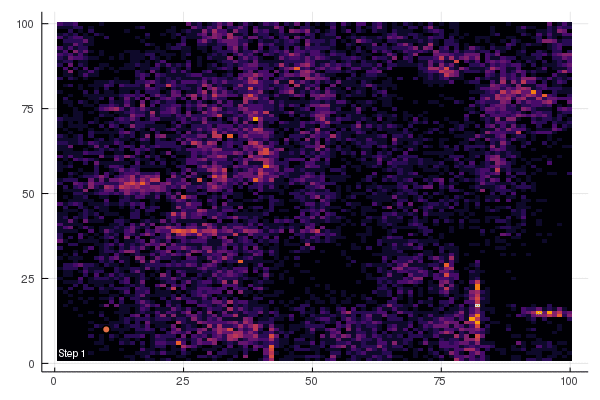

In [12]:
function PlotTrace(env::StepEnvironment{GridModel}, log)
    n_walkers = size(env.walkers,1)
    n_steps = size(log[1],1)
    img = @gif for i in 1:n_steps
        heatmap(env.model.grid, legend=false)
        scatter!(map(x->(x[i][2], x[i][1]), log))
        annotate!( [(1,3,Plots.text("Step $i", 7, :left, :white))] )
    end every 5
    img
end
PlotTrace(env, log)